In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Ler as bases
player_totals = pd.read_csv("Bases/Player Totals.csv", sep=",", encoding="latin1", low_memory=False)

pd.set_option('display.max_columns', None)

player_totals.head(5)

,season,lg,player,player_id,age,team,pos,g,gs,mp,fg,fga,fg_percent,x3p,x3pa,x3p_percent,x2p,x2pa,x2p_percent,e_fg_percent,ft,fta,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,2025,NBA,Precious Achiuwa,achiupr01,25.0,NYK,C,57,10.0,1170.0,164,327,0.502,10.0,36.0,0.278,154.0,291.0,0.529,0.517,41,69,0.594,101.0,216.0,317.0,55,47.0,42.0,45.0,81.0,379,0.0
1,2025,NBA,Steven Adams,adamsst01,31.0,HOU,C,58,3.0,794.0,91,167,0.545,0.0,2.0,0.000,91.0,165.0,0.552,0.545,43,93,0.462,166.0,161.0,327.0,66,22.0,28.0,54.0,60.0,225,0.0
2,2025,NBA,Bam Adebayo,adebaba01,27.0,MIA,C,78,78.0,2674.0,540,1113,0.485,79.0,221.0,0.357,461.0,892.0,0.517,0.521,251,328,0.765,185.0,564.0,749.0,337,98.0,53.0,161.0,162.0,1410,1.0
3,2025,NBA,Ochai Agbaji,agbajoc01,24.0,TOR,SG,64,45.0,1739.0,266,534,0.498,101.0,253.0,0.399,165.0,281.0,0.587,0.593,34,48,0.708,61.0,181.0,242.0,98,58.0,30.0,54.0,125.0,667,0.0
4,2025,NBA,Santi Aldama,aldamsa01,24.0,MEM,PF,65,16.0,1660.0,313,648,0.483,120.0,326.0,0.368,193.0,322.0,0.599,0.576,65,94,0.691,94.0,322.0,416.0,188,52.0,29.0,71.0,76.0,811,0.0


## Ajustando algumas bases


### player_totals

Na base `player_totals`, quando um jogador atua por mais de um time na mesma temporada, 
aparecem várias linhas referentes a essa mesma season:

- **Uma linha para cada time** (ex.: CHI, SAC, etc.)  
- **E também uma linha agregada** (`TOT`, `2TM`, `3TM`, `4TM`) com o total consolidado da temporada.  

Se simplesmente somarmos estatísticas como `mp` (minutos), `pts` (pontos), etc., 
acabamos **contando em dobro** (as linhas dos times + a linha agregada).

**Solução:** criar uma versão limpa (`df_no_dupes`) que aplica a seguinte regra:

- Se **existe** uma linha agregada (`TOT`/`2TM`/`3TM`/`4TM`), mantemos apenas essa linha.  
- Se **não existe**, mantemos as linhas individuais dos times.

In [3]:
import pandas as pd

AGG_LABELS = {"TOT", "2TM", "3TM", "4TM"}

def dedupe_tot(df: pd.DataFrame) -> pd.DataFrame:
    """Mantém apenas a linha TOT/2TM/3TM/4TM quando existir;
    caso não exista, mantém as linhas por time."""
    df = df.copy()
    df["team_norm"] = df["team"].astype(str).str.upper().str.strip()

    has_tot = (
        df.assign(is_tot=df["team_norm"].isin(AGG_LABELS))
          .groupby(["player_id", "season"])["is_tot"]
          .transform("any")
    )

    df_nodupes = df[(~has_tot) | (df["team_norm"].isin(AGG_LABELS))]\
                    .drop(columns=["team_norm"])
    return df_nodupes

# limpa duplicação
player_totals = dedupe_tot(player_totals)

In [4]:
linhas, colunas = player_totals.shape

print(f"Número de linhas: {linhas}")
print(f"Número de colunas: {colunas}")

Número de linhas: 26429
Número de colunas: 33


In [5]:
player_totals.dtypes

season            int64
lg               object
player           object
player_id        object
age             float64
team             object
pos              object
g                 int64
gs              float64
mp              float64
fg                int64
fga               int64
fg_percent      float64
x3p             float64
x3pa            float64
x3p_percent     float64
x2p             float64
x2pa            float64
x2p_percent     float64
e_fg_percent    float64
ft                int64
fta               int64
ft_percent      float64
orb             float64
drb             float64
trb             float64
ast               int64
stl             float64
blk             float64
tov             float64
pf              float64
pts               int64
trp_dbl         float64
dtype: object

In [6]:
player_totals.isnull().sum() 

season             0
lg                 0
player             0
player_id          0
age               16
team               0
pos              867
g                  0
gs              6578
mp               792
fg                 0
fga                0
fg_percent        94
x3p             5199
x3pa            5200
x3p_percent     8251
x2p             5199
x2pa            5199
x2p_percent     5332
e_fg_percent    5280
ft                 0
fta                0
ft_percent       809
orb             3777
drb             3777
trb              657
ast                0
stl             4490
blk             4488
tov             4636
pf                 1
pts                0
trp_dbl            3
dtype: int64

In [7]:
import sqlite3

# Criar conexão com banco em memória (ou use um arquivo .db se quiser salvar)
conn = sqlite3.connect(":memory:")
# Enviar o DataFrame para o SQLite
player_totals.to_sql("player_totals", conn, index=False, if_exists="replace")

26429

## Exemplo de query da base

In [8]:
query = """
SELECT * 
FROM player_totals
WHERE player_id = "lavinza01" AND season = 2025
"""

df_resultado = pd.read_sql_query(query, conn)
df_resultado

,season,lg,player,player_id,age,team,pos,g,gs,mp,fg,fga,fg_percent,x3p,x3pa,x3p_percent,x2p,x2pa,x2p_percent,e_fg_percent,ft,fta,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,2025,NBA,Zach LaVine,lavinza01,29.0,2TM,SF,74,74.0,2602.0,625,1223,0.511,239.0,536.0,0.446,386.0,687.0,0.562,0.609,235,285,0.825,22.0,293.0,315.0,310,58.0,12.0,208.0,121.0,1724,0.0


## Estatísticas dos jogadores

### Analisando os Pontos

#### TOP 10 jogadores por total de pontos na NBA

In [23]:
query = """
SELECT player, SUM(pts) AS total_pontos
FROM player_totals
GROUP BY player
ORDER BY total_pontos DESC
LIMIT 10;
"""

top10_scorers_all_time = pd.read_sql_query(query, conn)
top10_scorers_all_time

,player,total_pontos
0,LeBron James,42184
1,Kareem Abdul-Jabbar,38387
2,Karl Malone,36928
3,Kobe Bryant,33643
4,Michael Jordan,32292
5,Dirk Nowitzki,31560
6,Wilt Chamberlain,31419
7,Kevin Durant,30571
8,Julius Erving,30026
9,Moses Malone,29580


#### TOP 10 jogadores por total de pontos na NBA em 2025

In [24]:
query = """
SELECT player, SUM(pts) AS total_pontos
FROM player_totals
WHERE season = 2025
GROUP BY player
ORDER BY total_pontos DESC
LIMIT 10;
"""

top10_scorers_2025 = pd.read_sql_query(query, conn)
top10_scorers_2025

,player,total_pontos
0,Shai Gilgeous-Alexander,2484
1,Anthony Edwards,2177
2,Nikola JokiÄ,2071
3,Giannis Antetokounmpo,2036
4,Jayson Tatum,1932
5,Devin Booker,1923
6,Trae Young,1841
7,Tyler Herro,1840
8,Cade Cunningham,1830
9,James Harden,1802


#### Quantidade total de pontos de cada temporada

In [21]:
query = """
SELECT season, SUM(pts) as total_pts_temporada
FROM player_totals
GROUP BY season
ORDER BY season DESC;
"""

total_season_points = pd.read_sql_query(query, conn)
total_season_points

,season,total_pts_temporada
0,2025,280010
1,2024,280960
2,2023,282127
3,2022,272115
4,2021,242117
...,...,...
74,1951,59514
75,1950,89806
76,1949,57609
77,1948,27899


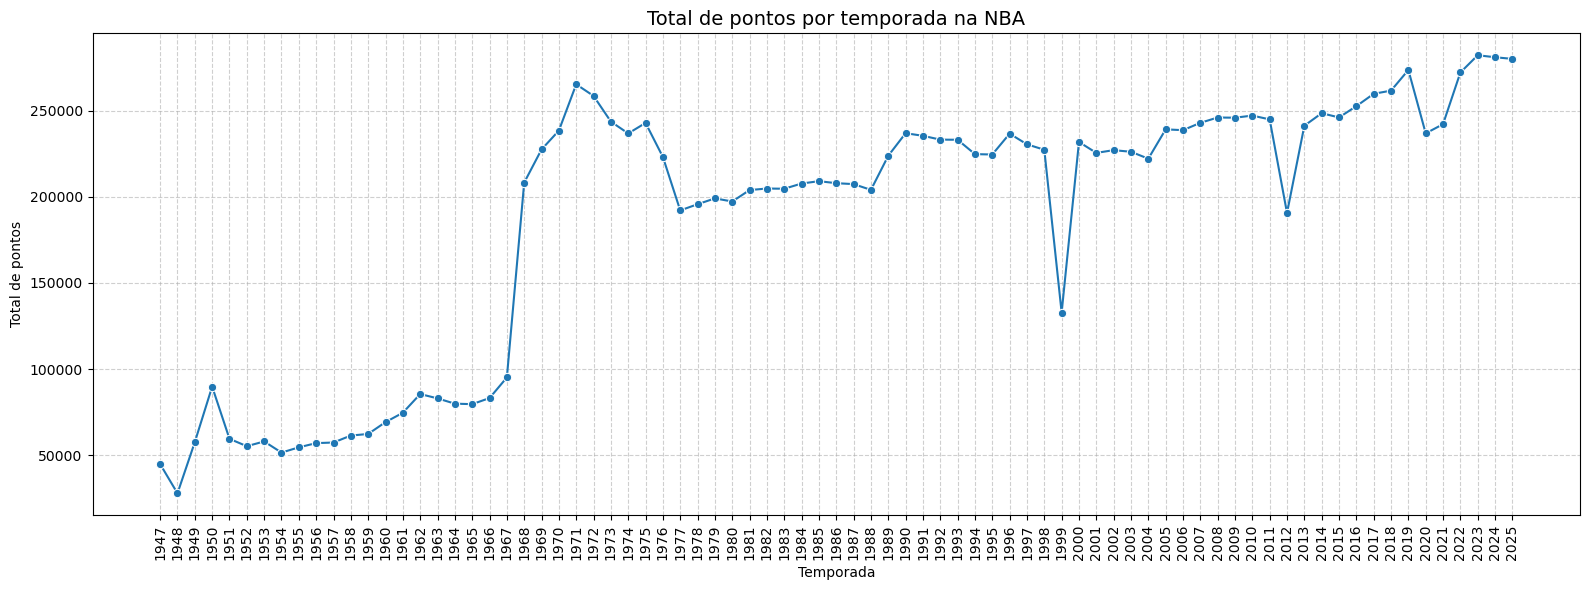

In [53]:
df = total_season_points.sort_values("season")

plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="season", y="total_pts_temporada", marker="o")

plt.title("Total de pontos por temporada na NBA", fontsize=14)
plt.xlabel("Temporada")
plt.ylabel("Total de pontos")

# força mostrar todas as temporadas no eixo X
plt.xticks(ticks=df["season"], rotation=90)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Ranking dos maiores ponturadores por cada season

In [22]:
query = """
SELECT season, player, pts,
    DENSE_RANK() OVER(
        PARTITION BY season 
        ORDER BY pts DESC
    ) AS ranking_mp
FROM player_totals
ORDER BY season DESC, pts DESC
"""

# Season | Jogador | Total Pontos | Ranking
# 2025 | LeBron | 3000 | 1
# ...

# Cada linha do player_totals = stats totais da season do jogador

season_scorers_ranked = pd.read_sql_query(query, conn)
season_scorers_ranked

,season,player,pts,ranking_mp
0,2025,Shai Gilgeous-Alexander,2484,1
1,2025,Anthony Edwards,2177,2
2,2025,Nikola JokiÄ,2071,3
3,2025,Giannis Antetokounmpo,2036,4
4,2025,Jayson Tatum,1932,5
...,...,...,...,...
26424,1947,Leon Brown,0,136
26425,1947,Ken Corley,0,136
26426,1947,Don Eliason,0,136
26427,1947,Pete Lalich,0,136


#### Jogador que mais pontou em cada season da NBA nos últimos 25 anos

In [47]:
query = """

-- CTE que cria um ranking por season trazendo os maiores pontuadores
WITH season_rank AS (
SELECT season, player, pts,
    DENSE_RANK() OVER(
        PARTITION BY season 
        ORDER BY pts DESC) AS ranking_pts
FROM player_totals
)

SELECT season, player
FROM season_rank
-- Somente o top 1
WHERE ranking_pts = 1
ORDER BY season DESC, ranking_pts
LIMIT 25;
"""

season_scorers_ranked = pd.read_sql_query(query, conn)
season_scorers_ranked

,season,player
0,2025,Shai Gilgeous-Alexander
1,2024,Luka DonÄiÄ
2,2023,Jayson Tatum
3,2022,Trae Young
4,2021,Stephen Curry
5,2020,James Harden
6,2019,James Harden
7,2018,LeBron James
8,2017,Russell Westbrook
9,2016,James Harden


In [61]:
query = """
SELECT season, sum(x3p)
FROM player_totals
GROUP BY season
ORDER BY season DESC, x3p DESC
"""
season_total_3pts = pd.read_sql_query(query, conn)
season_total_3pts

,season,sum(x3p)
0,2025,33304.0
1,2024,31579.0
2,2023,30359.0
3,2022,30598.0
4,2021,27427.0
...,...,...
74,1951,NaN
75,1950,NaN
76,1949,NaN
77,1948,NaN


In [70]:
query = """

-- CTE que cria um ranking por season trazendo os maiores pontuadores de 3 pontos
WITH season_rank AS (
SELECT season, player, x3p,
    DENSE_RANK() OVER(
        PARTITION BY season 
        ORDER BY x3p DESC) AS ranking_pts
FROM player_totals
)

SELECT season, player
FROM season_rank
-- Somente o top 1
WHERE ranking_pts = 1
ORDER BY season DESC, ranking_pts
"""

season_scorers_ranked = pd.read_sql_query(query, conn)
season_scorers_ranked

,season,player
0,2025,Anthony Edwards
1,2024,Stephen Curry
2,2023,Klay Thompson
3,2022,Stephen Curry
4,2021,Stephen Curry
...,...,...
3423,1947,Red Wallace
3424,1947,Jake Weber
3425,1947,Ray Wertis
3426,1947,Max Zaslofsky


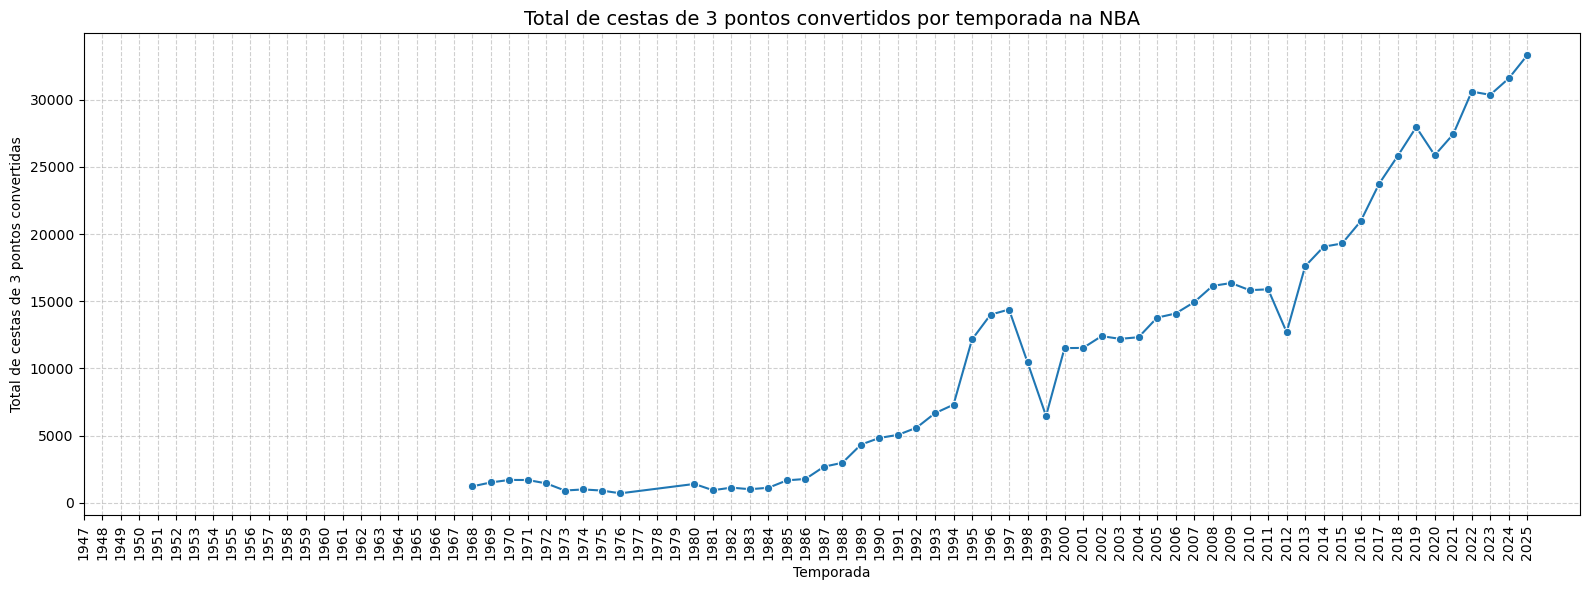

In [63]:
df = season_total_3pts.sort_values("season")

plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="season", y="sum(x3p)", marker="o")

plt.title("Total de cestas de 3 pontos convertidos por temporada na NBA", fontsize=14)
plt.xlabel("Temporada")
plt.ylabel("Total de cestas de 3 pontos convertidas")

# força mostrar todas as temporadas no eixo X
plt.xticks(ticks=df["season"], rotation=90)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Minutagem

#### TOP 10 jogadores ALL TIME por TOTAL de minutos jogados

In [32]:
query = """
SELECT player, SUM(mp) AS total_minutes, ROUND(SUM(mp)/60, 1) AS total_hours, ROUND(SUM(mp)*60, 1) AS total_seconds
FROM player_totals
GROUP BY player
ORDER BY total_minutes DESC
LIMIT 10;
"""

top10_total_minutes_2025 = pd.read_sql_query(query, conn)
top10_total_minutes_2025

df_resultado = pd.read_sql_query(query, conn)
df_resultado

,player,total_minutes,total_hours,total_seconds
0,LeBron James,59041.0,984.0,3542460.0
1,Kareem Abdul-Jabbar,57446.0,957.4,3446760.0
2,Karl Malone,54852.0,914.2,3291120.0
3,Eddie Johnson,52579.0,876.3,3154740.0
4,Dirk Nowitzki,51368.0,856.1,3082080.0
5,Kevin Garnett,50418.0,840.3,3025080.0
6,Jason Kidd,50111.0,835.2,3006660.0
7,Elvin Hayes,50000.0,833.3,3000000.0
8,Moses Malone,49444.0,824.1,2966640.0
9,Kobe Bryant,48637.0,810.6,2918220.0


#### Ranking do total de minutos jogados dos jogadores por season

In [25]:
query = """
SELECT season, player, mp,
    DENSE_RANK() OVER(
        PARTITION BY season 
        ORDER BY mp DESC
    ) AS ranking_mp
FROM player_totals
ORDER BY season DESC, mp DESC
"""

top10_total_minutes_2025 = pd.read_sql_query(query, conn)
top10_total_minutes_2025

,season,player,mp,ranking_mp
0,2025,Mikal Bridges,3036.0,1
1,2025,Josh Hart,2897.0,2
2,2025,Anthony Edwards,2871.0,3
3,2025,Devin Booker,2795.0,4
4,2025,James Harden,2789.0,5
...,...,...,...,...
26424,1947,Red Wallace,NaN,1
26425,1947,Jake Weber,NaN,1
26426,1947,Ray Wertis,NaN,1
26427,1947,Max Zaslofsky,NaN,1
